In [163]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')


from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

import scipy.stats as stats
from scipy.stats import shapiro, pearsonr
from itertools import combinations

In [135]:
df = pd.read_csv('./datasets/unlisted_resampled_train_data.csv')
df2 = pd.read_csv('./datasets/unlisted_test_data.csv')

In [136]:
df.head(3)

,Unnamed: 0,회사명,거래소코드,회계년도,CASH FLOW 대 부채비율,CASH FLOW 대 차입금비율,CASH FLOW 대 총자본비율,CASH FLOW 대 매출액비율,유동비율,당좌비율,...,경영자본회전률,총자본회전률,비유동자산회전률,유동자산회전률,영업년수,도입기,성숙기,성장기,쇠퇴기,부실판단
0,7716,(주)동남코리아,70118,2022,-18.74,-39.58,-3.41,-27.33,26.09,17.94,...,0.31,0.13,0.14,3.59,30.0,1,0,0,0,0.0
1,14799,실란트로주식회사,90776,2022,24.36,26.27,6.51,7.43,116.38,33.26,...,0.93,0.88,1.28,2.82,15.0,1,0,0,0,0.0
2,6639,주식회사휴디스텍,98702,2022,8.93,21.11,7.25,2.89,80.98,75.83,...,2.87,2.71,6.01,4.95,16.0,1,0,0,0,0.0


In [137]:
Enterprise = df[['회사명', '거래소코드', '회계년도']]

df = df[['CASH FLOW 대 부채비율', 'CASH FLOW 대 차입금비율', 'CASH FLOW 대 총자본비율', 'CASH FLOW 대 매출액비율', '유동비율',
       '당좌비율', '부채비율', '유동부채비율', '차입금의존도', '순운전자본비율', '현금비율', '유동자산구성비율',
       '자기자본구성비율', '자기자본순이익률', '경영자본순이익률', '매출액순이익률', '총자본사업이익률', '총자본영업이익률',
       '매출액영업이익률', '금융비용부담률', 'CROE', '총자산증가율', '총자본증가율', '유동자산증가율',
       '비유동자산증가율', '매출액증가율', '유형자산증가율', '부가가치(백만원)', '총자본투자효율', '설비투자효율',
       '부가가치율', '이윤분배율', '자본분배율', '총자산회전율', '매출채권회전률', '당좌자산회전률', '유형자산회전율',
       '경영자본회전률', '총자본회전률', '비유동자산회전률', '유동자산회전률', '영업년수', '도입기', '성숙기', '성장기',
       '쇠퇴기', '부실판단']]


In [138]:
# H가 1인 경우 이분산성 / H가 0인 경우 등분산
from scipy.stats import bartlett
def bartlett_test(col, p_value = 0.05, H = 1):
    list= []
    for i in col:
        T, p_val = bartlett(df[df['부실판단']==1][i], df[df['부실판단']==0][i]) 
        list.append([i, p_val])

    list = pd.DataFrame(list, columns = ['변수', 'p_value'])
    if H == 1:
        a = list[(list['p_value'] < p_value)][['변수', 'p_value']].sort_values('p_value')
        return a
    else:
        a = list[(list['p_value'] >= p_value)][['변수', 'p_value']].sort_values('p_value')
        return a

In [139]:
# 이분산성 변수
x_hetero = bartlett_test(df.columns, H = 1)
# 등분산성 변수
x_homo = bartlett_test(df.columns, H = 0)

In [140]:
# t-test

import scipy.stats as stats
def t_test(col, col_h0, col_h1, p_value = 0.05):
    list= []
    for i in col:
        if (col_h0['변수']==i).any():
            t_stat, p_val = stats.ttest_ind(df[df['부실판단']==1][i], df[df['부실판단']==0][i], equal_var=True) # 등분산성 : wald t-test
            list.append([i, p_val])
        elif (col_h1['변수']==i).any():
            t_stat, p_val = stats.ttest_ind(df[df['부실판단']==1][i], df[df['부실판단']==0][i], equal_var=False) # 이분산성 : welch’s t-test
            list.append([i, p_val])

    list = pd.DataFrame(list, columns = ['변수', 'p_value'])
    a = list[(list['p_value'] < p_value)][['변수', 'p_value']].sort_values('p_value')
    return a

In [141]:
# 2) t_test 결과 p_value < 0.05보다 작은 유의한 변수 가져오기
x_ttest = t_test(df.columns, x_homo, x_hetero, p_value=0.05)
print("유의한 피쳐 수 :", len(x_ttest))
x_ttest = x_ttest.sort_values(by="변수", ascending=True).reset_index(drop=True)
x_ttest

유의한 피쳐 수 : 29


,변수,p_value
0,CASH FLOW 대 매출액비율,1.525698e-20
1,CASH FLOW 대 부채비율,2.625388e-15
2,CASH FLOW 대 차입금비율,2.524259e-04
3,CASH FLOW 대 총자본비율,3.608749e-72
4,경영자본순이익률,2.667110e-57
5,경영자본회전률,4.278382e-56
6,금융비용부담률,3.734844e-28
7,당좌비율,8.146628e-04
8,매출액순이익률,1.184855e-06
9,매출액영업이익률,6.693427e-15


In [142]:
unlisted_columns = list(x_ttest['변수'])

In [143]:
x_train = df[unlisted_columns]
x_test = df2[unlisted_columns]

y_train = df['부실판단']
y_test = df2['부실판단']

In [144]:
model = LogisticRegression()
model.fit(x_train, y_train)
y_pred = model.predict(x_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

if len(np.unique(y_test)) == 2:  # 이진 분류인 경우에만 ROC AUC 계산
    roc_auc = roc_auc_score(y_test, y_pred)
    

print(f'Accuracy: {accuracy:.3f}')
print(f'Precision: {precision:.3f}')
print(f'Recall: {recall:.3f}')
print(f'F1 스코어: {f1:.2f}')
print(f'ROC AUC 스코어: {roc_auc:.2f}')


Accuracy: 0.711
Precision: 0.589
Recall: 0.655
F1 스코어: 0.62
ROC AUC 스코어: 0.70


In [145]:
# 피처 중요도 확인(회귀계수), 데이터프레임 만들고 내림차순 정렬
logit_fi = np.abs(model.coef_[0])
logit_fi_df = pd.DataFrame({'Feature': x_train.columns, 'Importance': logit_fi})
logit_fi_df = logit_fi_df.sort_values(by='Importance', ascending=False)

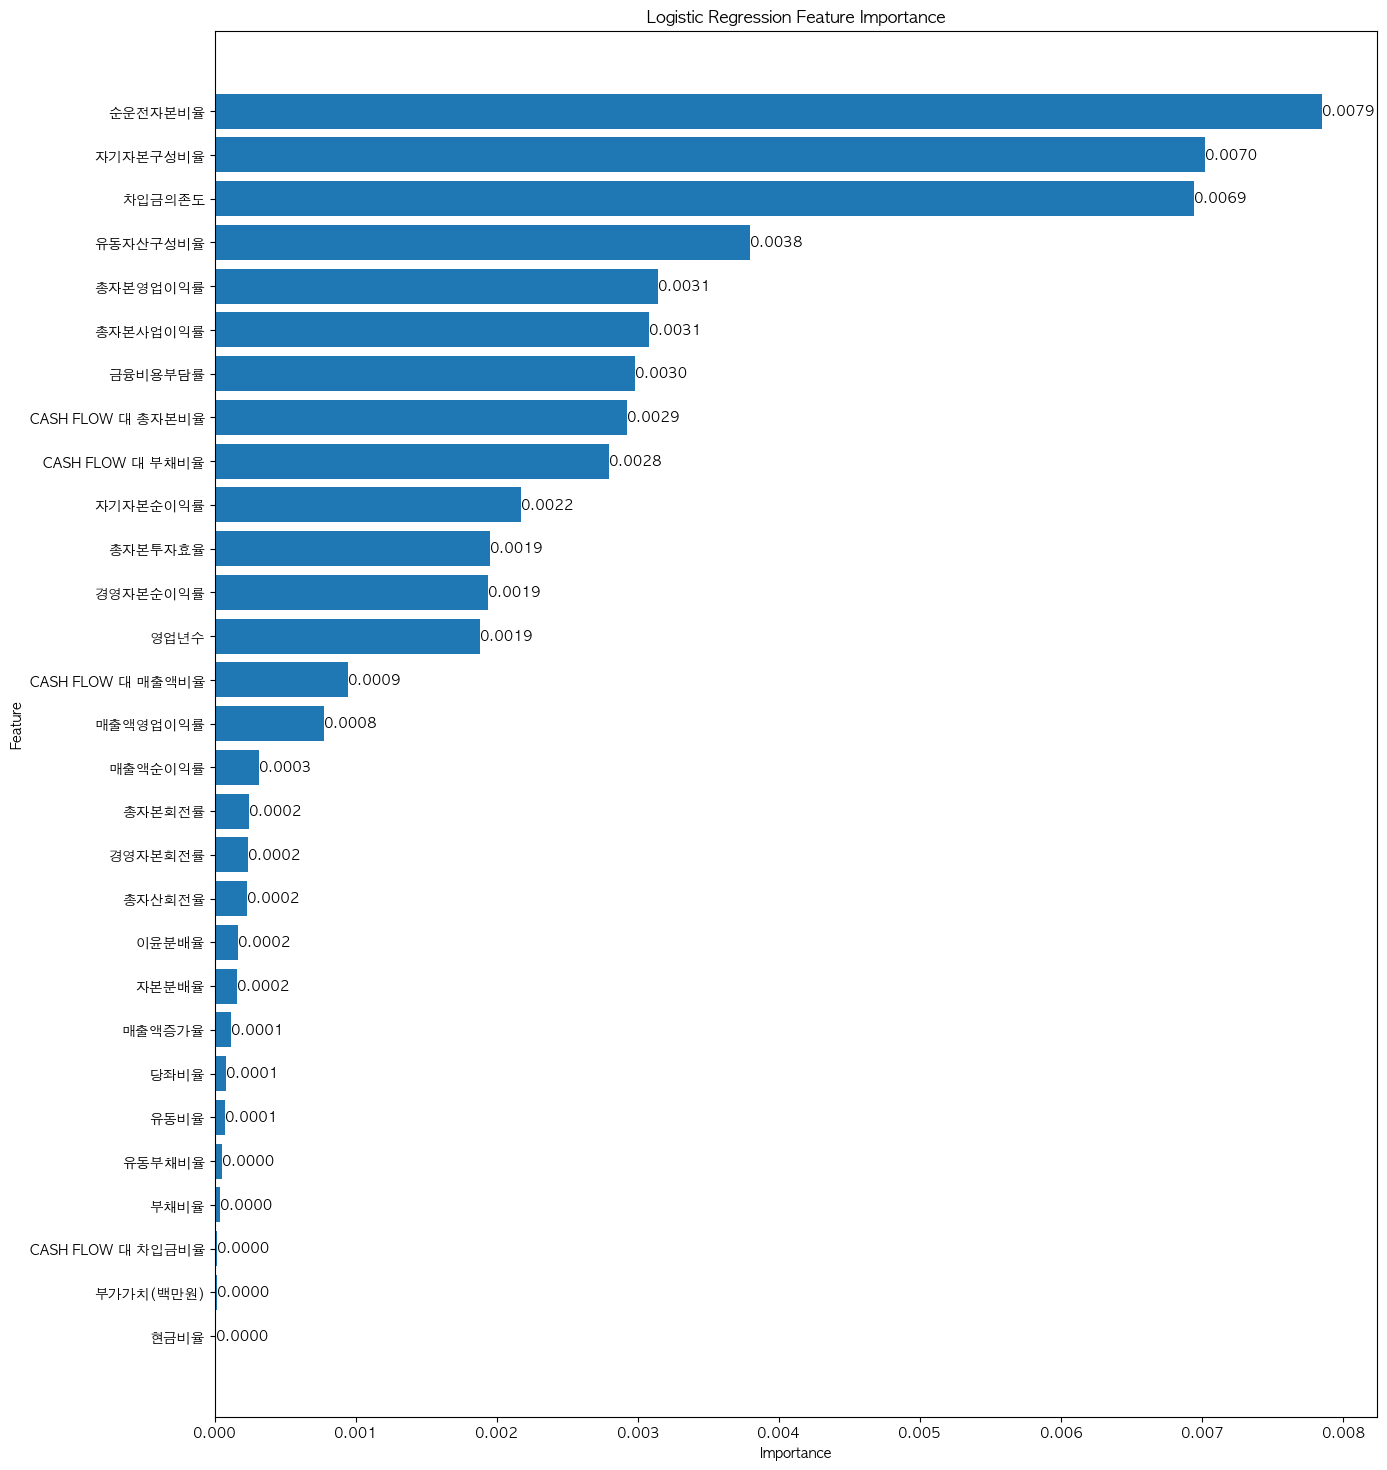

In [146]:
# 중요도 시각화
plt.rcParams['font.family'] = 'AppleGothic'
plt.figure(figsize=(15, 18))
bars = plt.barh(logit_fi_df['Feature'], logit_fi_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Logistic Regression Feature Importance')
plt.gca().invert_yaxis()

# 피처 중요도 값 표시
for bar, importance in zip(bars, logit_fi_df['Importance']):
    plt.text(importance, bar.get_y() + bar.get_height()/2, f'{importance:.4f}', ha='left', va='center')

plt.show()

### t-test로 필터링된 피처들의 상관관계 확인

<Axes: >

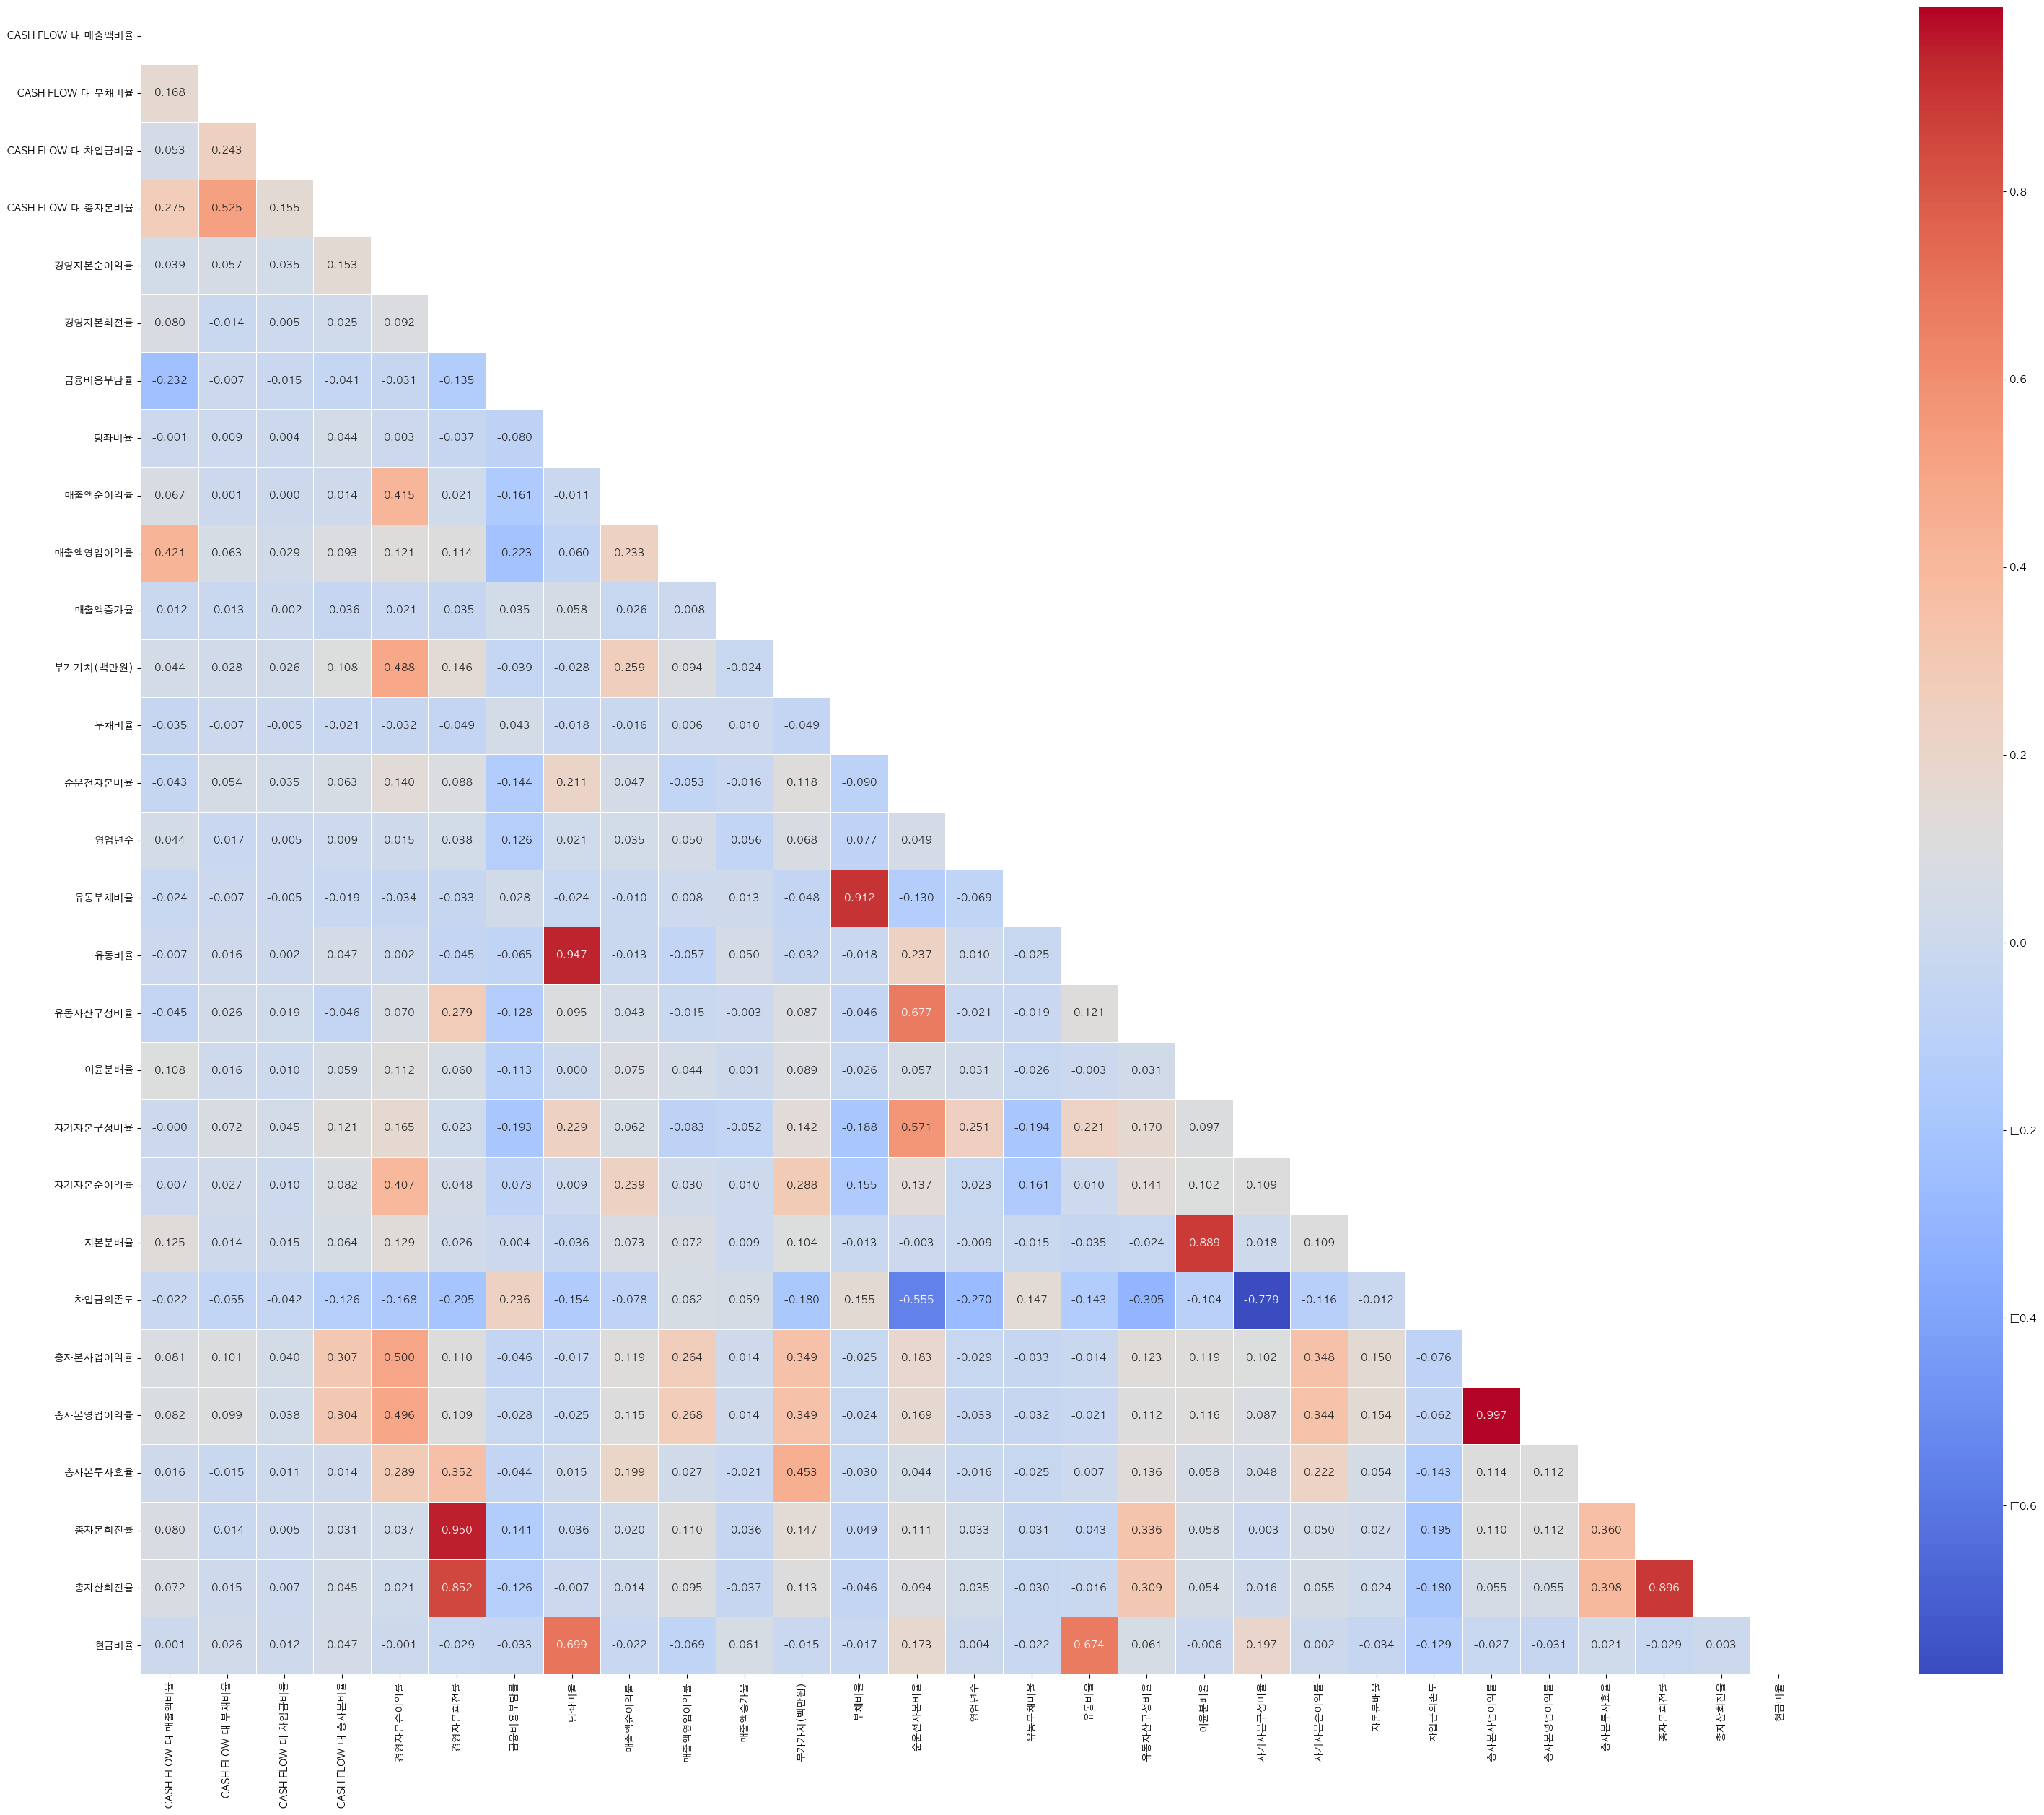

In [147]:
plt.figure(figsize=(40,30))
mask = np.triu(np.ones_like(x_train.corr(), dtype=bool))
sns.heatmap(x_train.corr(), 
            annot=True,
            annot_kws={'size' : 10}, # 숫자 출력 시 숫자 크기 조절
            fmt = '.3f', # 숫자의 출력 소수점자리 개수 조절
            square = True, # 차트를 정사각형으로 할 것인지
            cmap='coolwarm', 
            linewidths=.5, 
            mask = mask)

In [148]:
# 상관 계수와 p-value 계산하는 함수
def correlation_and_pval(df):
    columns = df.columns
    corr_dict = {}
    pval_dict = {}
    
    # 모든 특성 쌍에 대한 상관 계수와 p-value 계산
    for col1, col2 in combinations(columns, 2):
        corr, pval = pearsonr(df[col1], df[col2])
        corr_dict[f"{col1}-{col2}"] = corr
        pval_dict[f"{col1}-{col2}"] = pval
    
    return corr_dict, pval_dict

In [149]:
def check_multicollinearity(df, threshold=0.8):
    corr_dict, pval_dict = correlation_and_pval(df)
    multicollinear_vars = []

    for pair, corr in corr_dict.items():
        if abs(corr) >= threshold:
            var1, var2 = pair.split('-')
            multicollinear_vars.append((var1, var2, corr, pval_dict[pair]))

    return multicollinear_vars

# 위 함수를 사용하여 다중공선성 확인
multicollinear_vars = check_multicollinearity(df)

if len(multicollinear_vars) > 0:
    print("상관 계수가 높은 변수관계 (변수1, 변수2, 상관 계수, p-value):")
    for var1, var2, corr, pval in multicollinear_vars:
        print(f"{var1}-{var2} : {corr:.3f}, {pval:.3f}")
else:
    print("상관 관계의 변수가 없음")

상관 계수가 높은 변수관계 (변수1, 변수2, 상관 계수, p-value):
유동비율-당좌비율 : 0.947, 0.000
부채비율-유동부채비율 : 0.912, 0.000
매출액순이익률-부가가치율 : 0.867, 0.000
총자본사업이익률-총자본영업이익률 : 0.997, 0.000
총자산증가율-총자본증가율 : 0.937, 0.000
이윤분배율-자본분배율 : 0.889, 0.000
총자산회전율-경영자본회전률 : 0.852, 0.000
총자산회전율-총자본회전률 : 0.896, 0.000
경영자본회전률-총자본회전률 : 0.950, 0.000


In [150]:
# 상관계수 확인 함수를 이용하여 상관관계가 높은 변수 쌍 찾기
def check_multicollinearity(df, threshold=0.8):
    corr_dict, _ = correlation_and_pval(df)
    multicollinear_vars = []

    for pair, corr in corr_dict.items():
        if abs(corr) >= threshold:
            var1, var2 = pair.split('-')
            multicollinear_vars.append(var1)
            multicollinear_vars.append(var2)

    # 중복 제거 후 상관관계가 높은 변수들의 리스트 반환
    return list(set(multicollinear_vars))

# 상관관계가 높은 변수 추출
high_correlation_vars = check_multicollinearity(df)

# 상관관계가 높은 변수들로 이루어진 데이터프레임 생성
high_corr_df = df[high_correlation_vars]

In [151]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calculate_vif(df):
    vif_data = df.copy()
    vif_data = vif_data.dropna()  # 결측치 제거 (VIF 계산 시 필요)

    variables = vif_data.columns
    vif = pd.DataFrame()
    vif["Variable"] = variables
    vif["VIF"] = [variance_inflation_factor(vif_data.values, i) for i in range(vif_data.shape[1])]

    return vif

# calculate_vif 함수를 사용하여 각 변수의 VIF 계산
vif_result = calculate_vif(high_corr_df)

# VIF가 10보다 큰 변수 확인
high_vif_vars = vif_result[vif_result['VIF'] > 10]
print(high_vif_vars)


    Variable         VIF
3       당좌비율   10.079918
4   총자본사업이익률  135.665211
8   총자본영업이익률  135.573811
11    총자본회전률   24.542327
12      유동비율   10.057603
14   경영자본회전률   17.444263


In [152]:
x_train.columns

Index(['CASH FLOW 대 매출액비율', 'CASH FLOW 대 부채비율', 'CASH FLOW 대 차입금비율',
       'CASH FLOW 대 총자본비율', '경영자본순이익률', '경영자본회전률', '금융비용부담률', '당좌비율',
       '매출액순이익률', '매출액영업이익률', '매출액증가율', '부가가치(백만원)', '부채비율', '순운전자본비율', '영업년수',
       '유동부채비율', '유동비율', '유동자산구성비율', '이윤분배율', '자기자본구성비율', '자기자본순이익률', '자본분배율',
       '차입금의존도', '총자본사업이익률', '총자본영업이익률', '총자본투자효율', '총자본회전률', '총자산회전율',
       '현금비율'],
      dtype='object')

In [153]:
x_train = x_train.drop(columns=['당좌비율', '총자본사업이익률', '총자본영업이익률', '총자본회전률', '유동비율', '경영자본회전률'])
x_test = x_test.drop(columns=['당좌비율', '총자본사업이익률', '총자본영업이익률', '총자본회전률', '유동비율', '경영자본회전률'])

y_train = df['부실판단']
y_test = df2['부실판단']

In [154]:
len(y_test)

5569

In [155]:
model = LogisticRegression()
model.fit(x_train, y_train)
y_pred = model.predict(x_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

if len(np.unique(y_test)) == 2:  # 이진 분류인 경우에만 ROC AUC 계산
    roc_auc = roc_auc_score(y_test, y_pred)
    

print(f'Accuracy: {accuracy:.3f}')
print(f'Precision: {precision:.3f}')
print(f'Recall: {recall:.3f}')
print(f'F1 스코어: {f1:.2f}')
print(f'ROC AUC 스코어: {roc_auc:.2f}')

Accuracy: 0.706
Precision: 0.581
Recall: 0.661
F1 스코어: 0.62
ROC AUC 스코어: 0.70


In [156]:
x_train['부실판단'] = y_train
X = x_train

In [157]:
X.isna().sum()

CASH FLOW 대 매출액비율    0
CASH FLOW 대 부채비율     0
CASH FLOW 대 차입금비율    0
CASH FLOW 대 총자본비율    0
경영자본순이익률             0
금융비용부담률              0
매출액순이익률              0
매출액영업이익률             0
매출액증가율               0
부가가치(백만원)            0
부채비율                 0
순운전자본비율              0
영업년수                 0
유동부채비율               0
유동자산구성비율             0
이윤분배율                0
자기자본구성비율             0
자기자본순이익률             0
자본분배율                0
차입금의존도               0
총자본투자효율              0
총자산회전율               0
현금비율                 0
부실판단                 0
dtype: int64

In [158]:
# Forward Selection

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# 학습 데이터와 검증 데이터 분리
X_train, X_val, y_train, y_val = train_test_split(X.drop(columns='부실판단'), X['부실판단'], test_size=0.2, random_state=42)

# Forward feature selection 수행
selected_features = []
best_score = 0

while len(selected_features) < X.shape[1]:
    best_feature = None
    best_model = None
    best_score_local = 0

    for feature in X_train.columns:
        if feature not in selected_features:
            features = selected_features + [feature]
            X_train_selected = X_train[features]
            X_val_selected = X_val[features]

            model = LogisticRegression()
            model.fit(X_train_selected, y_train)
            score = model.score(X_val_selected, y_val)

            if score > best_score_local:
                best_score_local = score
                best_feature = feature
                best_model = model

    if best_score_local > best_score:
        selected_features.append(best_feature)
        best_score = best_score_local
        print(f"Selected feature: {best_feature}, Accuracy: {best_score:.4f}")

    else:
        break

Forward = selected_features
print("\nForward selected features:", Forward)

Selected feature: 자기자본순이익률, Accuracy: 0.6822

Forward selected features: ['자기자본순이익률']


In [159]:
# Backward Elimination
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# 학습 데이터와 검증 데이터 분리
X_train, X_val, y_train, y_val = train_test_split(X.drop(columns='부실판단'), X['부실판단'], test_size=0.2, random_state=42)

# Backward feature selection 수행
selected_features = X_train.columns.tolist()
best_score = 0

while len(selected_features) > 0:
    worst_feature = None
    best_model = None
    best_score_local = 0

    for feature in selected_features:
        features = selected_features.copy()
        features.remove(feature)

        X_train_selected = X_train[features]
        X_val_selected = X_val[features]

        model = LogisticRegression()
        model.fit(X_train_selected, y_train)
        score = model.score(X_val_selected, y_val)

        if score > best_score_local:
            best_score_local = score
            worst_feature = feature
            best_model = model

    if best_score_local > best_score:
        selected_features.remove(worst_feature)
        best_score = best_score_local
        print(f"Removed feature: {worst_feature}, Accuracy: {best_score:.4f}")

    else:
        break

Backward = selected_features
print("\nFinal selected features:", Backward)


Removed feature: 부가가치(백만원), Accuracy: 0.6765
Removed feature: 유동부채비율, Accuracy: 0.6978
Removed feature: CASH FLOW 대 부채비율, Accuracy: 0.7053

Final selected features: ['CASH FLOW 대 매출액비율', 'CASH FLOW 대 차입금비율', 'CASH FLOW 대 총자본비율', '경영자본순이익률', '금융비용부담률', '매출액순이익률', '매출액영업이익률', '매출액증가율', '부채비율', '순운전자본비율', '영업년수', '유동자산구성비율', '이윤분배율', '자기자본구성비율', '자기자본순이익률', '자본분배율', '차입금의존도', '총자본투자효율', '총자산회전율', '현금비율']


In [164]:
lasso_model = LogisticRegression()
param_grid = {'penalty' : ['l1'], 
                'C' : [0.001, 0.01, 0.1, 1, 2, 5, 10],
                'solver' : ['liblinear']}

grid_search = GridSearchCV(lasso_model, param_grid=param_grid, return_train_score=True, cv=5)
grid_search.fit(X_train, y_train)

df = pd.DataFrame(grid_search.cv_results_)
df = df.sort_values(by=['rank_test_score'], ascending=True)
df[['params', 'mean_train_score', 'mean_test_score', 'rank_test_score']]
print('GridSearchCV 최적 파라미터:', grid_search.best_params_)
print('GridSearchCV 최고 정확도:{0:.4f}'.format(grid_search.best_score_))

GridSearchCV 최적 파라미터: {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}
GridSearchCV 최고 정확도:0.6979


In [175]:
lasso_best = LogisticRegression(C=0.0001, penalty='l1', solver='liblinear').fit(X_train, y_train)

df_lasso = pd.DataFrame()
df_lasso['feature'] = X_train.columns
df_lasso['coef'] = lasso_best.coef_[0]
df_lasso.drop(df_lasso[df_lasso['coef']==0].index, inplace=True)
df_lasso = df_lasso.reset_index(drop=True)
df_lasso

,feature,coef
0,CASH FLOW 대 매출액비율,-0.000728
1,CASH FLOW 대 부채비율,-0.000784
2,CASH FLOW 대 차입금비율,-0.000035
3,매출액영업이익률,-0.000647
4,매출액증가율,0.000117
5,부가가치(백만원),-0.000052
6,부채비율,0.000031
7,순운전자본비율,-0.006259
8,유동부채비율,-0.000001
9,이윤분배율,-0.000519


In [176]:
# 라쏘에서 선택된 피처
lasso = df_lasso['feature'].values.tolist()
print('Lasso에서 선택된 피처 수 {0:1.0f}'.format(len(df_lasso)), '개')
lasso

Lasso에서 선택된 피처 수 13 개


['CASH FLOW 대 매출액비율',
 'CASH FLOW 대 부채비율',
 'CASH FLOW 대 차입금비율',
 '매출액영업이익률',
 '매출액증가율',
 '부가가치(백만원)',
 '부채비율',
 '순운전자본비율',
 '유동부채비율',
 '이윤분배율',
 '자기자본구성비율',
 '자기자본순이익률',
 '차입금의존도']

In [177]:
list_Forward = list(Forward)
list_Backward = list(Backward)
# list_Stepwise = list(Stepwise)
# list_ttest= list(ttest)
list_lasso = list(lasso)
list_col_all = X_train.columns

In [178]:
def func_Forward(x):
    if x in list_Forward:
        return 1
    else:
        return 0
    
def func_Backward(x):
    if x in list_Backward:
        return 1
    else:
        return 0


# def func_Stepwise(x):
#     if x in list_Stepwise:
#         return 1
#     else:
#         return 0

# def func_ttest(x):
#     if x in list_ttest:
#         return 1
#     else:
#         return 0
    
def func_lasso(x):
    if x in list_lasso:
        return 1
    else:
        return 0

In [179]:
# 2번 선택된 Feature

feature_counts = pd.DataFrame()
feature_counts['Feature'] = list_col_all
feature_counts['Forward'] = list_col_all.map(func_Forward)
feature_counts['Backward'] = list_col_all.map(func_Backward)
# feature_counts['Stepwise'] = list_col_all.map(func_Stepwise)
# feature_counts['ttest'] = list_col_all.map(func_ttest)
feature_counts['lasso'] = list_col_all.map(func_lasso)

feature_counts["total"] = feature_counts["Forward"]+feature_counts['Backward']+feature_counts["lasso"]
feature_final = feature_counts[feature_counts["total"]>=2]
list_feature_final = list(feature_final["Feature"])
print("선택된 피쳐수 :", len(list_feature_final))
feature_final = feature_final.sort_values('total', ascending=False).reset_index(drop=True)
feature_final

선택된 피쳐수 : 10


,Feature,Forward,Backward,lasso,total
0,자기자본순이익률,1,1,1,3
1,CASH FLOW 대 매출액비율,0,1,1,2
2,CASH FLOW 대 차입금비율,0,1,1,2
3,매출액영업이익률,0,1,1,2
4,매출액증가율,0,1,1,2
5,부채비율,0,1,1,2
6,순운전자본비율,0,1,1,2
7,이윤분배율,0,1,1,2
8,자기자본구성비율,0,1,1,2
9,차입금의존도,0,1,1,2


In [184]:
x_train = df[['자기자본순이익률', 'CASH FLOW 대 매출액비율', 'CASH FLOW 대 차입금비율', '매출액영업이익률', '매출액증가율', 
              '부채비율', '순운전자본비율', '이윤분배율', '자기자본구성비율', '차입금의존도']]
# x_test = df2[['자기자본순이익률', 'CASH FLOW 대 매출액비율', 'CASH FLOW 대 차입금비율', '매출액영업이익률', '매출액증가율', 
#               '부채비율', '순운전자본비율', '이윤분배율', '자기자본구성비율', '차입금의존도']]

# y_train = df['부실판단']
# y_test = df2['부실판단']

KeyError: "None of [Index(['자기자본순이익률', 'CASH FLOW 대 매출액비율', 'CASH FLOW 대 차입금비율', '매출액영업이익률',\n       '매출액증가율', '부채비율', '순운전자본비율', '이윤분배율', '자기자본구성비율', '차입금의존도'],\n      dtype='object')] are in the [columns]"